In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
import pandas as pd
from utils.deepmatcher_utils import wrapDm
import numpy as np

In [4]:
pd.set_option('display.max_colwidth',None)

## Black-box explanation

In [5]:
from utils.triangles_method import explainSamples

In [11]:
DATA_DIR ='../../datasets/Structured/Fodors-Zagats/'
allSamples = pd.read_csv(DATA_DIR+'complete-dataset.csv')

In [7]:
hybrid = dm.MatchingModel(attr_summarizer='hybrid')
hybrid.load_state('../../models/fod_zag_hybrid.pth')
hybrid = hybrid.to('cuda')

In [8]:
rnn = dm.MatchingModel(attr_summarizer='rnn')
rnn.load_state('../../models/fod_zag_rnn.pth')
rnn = rnn.to('cuda')

In [12]:
prediction = wrapDm(allSamples,rnn,ignore_columns=['label'])
correct_preds = allSamples[np.argmax(prediction,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds)

NameError: name 'rnn' is not defined

In [13]:
prediction4hybrid = wrapDm(allSamples,hybrid,ignore_columns=['label'])
correct_preds4hybrid = allSamples[np.argmax(prediction4hybrid,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds4hybrid)

(946, 943)

In [9]:
fodors = pd.read_csv(DATA_DIR+'tableA.csv',dtype=str)
zagats = pd.read_csv(DATA_DIR+'tableB.csv',dtype=str)

In [16]:
neg_ranking,flippedneg = explainSamples(correct_preds,[fodors,zagats],rnn,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=1)

100%|██████████| 600/600 [01:24<00:00,  7.10it/s]


In [18]:
pos_ranking,flippedpos = explainSamples(correct_preds,[fodors,zagats],rnn,wrapDm,
                                       class_to_explain=1,maxLenAttributeSet=1)

100%|██████████| 600/600 [01:19<00:00,  7.51it/s]


In [14]:
neg_ranking4hybrid,flippedneg4hybrid = explainSamples(correct_preds4hybrid,[fodors,zagats],hybrid,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=1)

100%|██████████| 592/592 [03:05<00:00,  3.19it/s]


In [ ]:
pos_ranking4hybrid,flippedpos4hybrid = explainSamples(correct_preds4hybrid,[fodors,zagats],hybrid,wrapDm,
                                       class_to_explain=1,maxLenAttributeSet=1)

 96%|█████████▌| 567/592 [03:04<00:09,  2.56it/s]

In [22]:
flippedneg.to_csv('rnn_flippedneg.csv',index=False)

In [14]:
flippedpos.to_csv('rnn_flippedpos.csv',index=False)

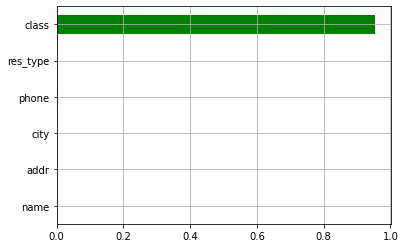

In [21]:
pos_ranking.plot.barh(color='green',grid=True).get_figure().savefig('rnn_pos_ranking.png')

In [ ]:
pos_ranking4hybrid.plot.barh(color='green',grid=True).get_figure().savefig('hybrid_pos_ranking.png')

In [ ]:
neg_ranking4hybrid.plot.barh(color='red',grid=True).get_figure().savefig('hybrid_neg_ranking.png')

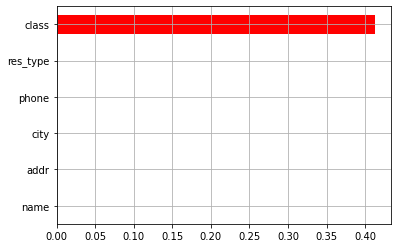

In [26]:
neg_ranking.plot.barh(color='red',grid=True).get_figure().savefig('rnn_neg_ranking.png')

In [27]:
flippedneg.to_csv('rnn_flippedneg.csv',index=False)
flippedpos.to_csv('rnn_flippedpos.csv',index=False)
flippedneg4hybrid.to_csv('hybrid_flippedneg.csv',index=False)
flippedpos4hybrid.to_csv('hybrid_flippedpos.csv',index=False)

## Patterns extraction

In [15]:
import ast,re
from utils.patternDiscovery import getMaxFrequentPatterns

In [22]:
flippedneg = pd.read_csv('hybrid_flippedneg.csv')
flippedpos = pd.read_csv('hybrid_flippedpos.csv')

In [27]:
flippedneg['alteredAttributes'] = flippedneg['alteredAttributes'].apply(lambda t:ast.literal_eval(t))
flippedpos['alteredAttributes'] = flippedpos['alteredAttributes'].apply(lambda t:ast.literal_eval(t))

In [30]:
flippedpos['ltable_name'] = flippedpos['ltable_name'].apply(lambda v:re.sub('[^\sa-zA-Z0-9-_*.]', '', v))
flippedpos['rtable_name'] = flippedpos['rtable_name'].apply(lambda v:re.sub('[^\sa-zA-Z0-9-_*.]', '', v))

In [33]:
neg_pattern_on_name = getMaxFrequentPatterns(flippedpos[flippedpos.alteredAttributes==('name',)],
                                             ['ltable_name','rtable_name'],min_support=0.1)

[['L_cafe', 'L_ritz-carlton', 'L_buckhead', 'R_toulouse'], ['L_cafe', 'L_ritz-carlton', 'L_buckhead', 'R_tomtom'], ['L_cafe', 'L_ritz-carlton', 'L_buckhead', 'R_palisades'], ['L_ritz-carlton', 'L_cafe', 'L_buckhead', 'R_toulouse']]


In [34]:
neg_pattern_on_name.head(10)

,support,itemsets
0,0.109524,(L_cafe)
1,0.130952,(L_s)
2,0.219048,(R_s)


In [29]:
pos_pattern_on_title = getMaxFrequentPatterns(flippedneg[flippedneg.alteredAttributes==('name',)],
                                             ['ltable_name','rtable_name'],min_support=0.2)
pos_pattern_on_title.head(10)

,support,itemsets
0,0.700581,"(R_`, L_`, R_', L_')"


## Test pattern influence

In [11]:
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')
positives = test_df[test_df.label==1].copy()
len(positives)

193

In [12]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==0)

63

In [82]:
positives = test_df[test_df.label==1].copy()
positives['ltable_title'] =  positives['ltable_title']+ " -"
positives['rtable_title'] =  positives['rtable_title']+ " " 

In [83]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==0)

67

In [ ]:
s = "rear projection screen x format"